In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import copy
import random
import time

import os.path
import json
import codecs

import cv2
import numpy as np
import pandas as pd

from tqdm import trange
from tqdm import tqdm as tqdm

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

In [ ]:
TRAIN_IMAGES_PATH = '../input/coco2017/train2017/train2017'
INASANCES_ANN_TRAIN_PATH = "../input/coco2017/annotations_trainval2017/annotations/instances_train2017.json"

VALID_IMAGES_PATH = '../input/coco2017/val2017/val2017'
INASANCES_ANN_VALID_PATH = "../input/coco2017/annotations_trainval2017/annotations/instances_val2017.json"

In [ ]:
with codecs.open(INASANCES_ANN_TRAIN_PATH, 'r', encoding='utf-8', errors='ignore') as f:
    train_ann = json.load(f)
    
with codecs.open(INASANCES_ANN_VALID_PATH, 'r', encoding='utf-8', errors='ignore') as f:
    valid_ann = json.load(f)

In [ ]:
# Load and mergs annotation
valid_df_images = pd.DataFrame(valid_ann['images'], columns=['file_name', 'height', 'width', 'id'])
valid_df_images.rename(columns = {'id':'image_id'}, inplace=True)

valid_df_bbox = pd.DataFrame(valid_ann['annotations'], columns=['bbox', 'category_id', 'image_id', 'iscrowd'])
valid_df_bbox = valid_df_bbox[valid_df_bbox.iscrowd==0]

valid_df_categories = pd.DataFrame(valid_ann['categories'])
valid_df_categories.rename(columns = {'id':'category_id'}, inplace=True)

valid_df_images = valid_df_images.merge(valid_df_bbox, on='image_id', how='inner')
valid_df_images = valid_df_images.merge(valid_df_categories, on='category_id', how='inner')
valid_df_images.sort_values(by=['file_name'], inplace=True)

# Make valid data map
valid_images_box_map = dict()
current_fname = None
# for b in tqdm(valid_df_images[valid_df_images.name == 'clock'].values):
for b in tqdm(valid_df_images.values):
    file_name, _, _, _, bbox, _, _,name, _ = b
    bbox = copy.deepcopy(bbox)
    bbox.append(name)
    
    if file_name != current_fname:
        valid_images_box_map[file_name] = list()
        current_fname = file_name
    valid_images_box_map[file_name].append(bbox)
# valid_images_box_map


In [ ]:
# Load and mergs annotation
train_df_images = pd.DataFrame(train_ann['images'], columns=['file_name', 'height', 'width', 'id'])
train_df_images.rename(columns = {'id':'image_id'}, inplace=True)

train_df_bbox = pd.DataFrame(train_ann['annotations'], columns=['bbox', 'category_id', 'image_id', 'iscrowd'])
train_df_bbox = train_df_bbox[train_df_bbox.iscrowd==0]

train_df_categories = pd.DataFrame(train_ann['categories'])
train_df_categories.rename(columns = {'id':'category_id'}, inplace=True)

train_df_images = train_df_images.merge(train_df_bbox, on='image_id', how='inner')
train_df_images = train_df_images.merge(train_df_categories, on='category_id', how='inner')
train_df_images.sort_values(by=['file_name'], inplace=True)

# Make valid data map
train_images_box_map = dict()
current_fname = None
# for b in tqdm(train_df_images[train_df_images.name == 'clock'].values):
for b in tqdm(train_df_images.values):
    file_name, _, _, _, bbox, _, _,name, _ = b
    bbox = copy.deepcopy(bbox)
    bbox.append(name)
    
    if file_name != current_fname:
        train_images_box_map[file_name] = list()
        current_fname = file_name
    train_images_box_map[file_name].append(bbox)
# train_images_box_map

In [ ]:
def read_image(fpath, brg2rgb=True):
    image = cv2.imread(fpath)
    if brg2rgb:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def show_image_with_bboxes(image, bboxes):
    plt.figure(figsize=(15,15))
    plt.imshow(image)
    plt.axis('off')
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for bbox in bboxes:
        c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
        bbox_x, bbox_y, bbox_w, bbox_h, label = bbox
        poly = [[bbox_x, bbox_y], [bbox_x, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y]]
        np_poly = np.array(poly).reshape((4,2))
        polygon = Polygon(np_poly)
        polygons.append(polygon)
        
        text = plt.text(bbox_x, bbox_y, label, verticalalignment='bottom', fontweight='heavy', color=c)
        color.append(c)

    p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
    ax.add_collection(p)
    p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
    ax.add_collection(p)

    
def show_image_with_bboxes_from_bbox_map(fname, image_path, bbox_map):
    image = read_image(os.path.join(image_path, fname))
    bboxes = bbox_map[fname]
    show_image_with_bboxes(image, bboxes)

In [ ]:
show_image_with_bboxes_from_bbox_map(random.choice([i for i in valid_images_box_map.keys()]), VALID_IMAGES_PATH, valid_images_box_map)

In [ ]:
!git clone https://github.com/ultralytics/yolov5
!pip install -r ./yolov5/requirements.txt

%cd yolov5
!weights/download_weights.sh


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [ ]:
def letterbox(img, new_shape=(416, 416), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    # Resize image to a 32-pixel-multiple rectangle https://github.com/ultralytics/yolov3/issues/232
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, 64), np.mod(dh, 64)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = new_shape
        ratio = new_shape[0] / shape[1], new_shape[1] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)


def scale_coords(img1_shape, coords, img0_shape, ratio_pad=None):
    # Rescale coords (xyxy) from img1_shape to img0_shape
    if ratio_pad is None:  # calculate from img0_shape
        gain = max(img1_shape) / max(img0_shape)  # gain  = old / new
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    coords[:, [0, 2]] -= pad[0]  # x padding
    coords[:, [1, 3]] -= pad[1]  # y padding
    coords[:, :4] /= gain
    clip_coords(coords, img0_shape)
    return coords

def non_max_suppression(prediction, conf_thres=0.1, iou_thres=0.6, fast=False, classes=None, agnostic=False):
    """Performs Non-Maximum Suppression (NMS) on inference results

    Returns:
         detections with shape: nx6 (x1, y1, x2, y2, conf, cls)
    """
    if prediction.dtype is torch.float16:
        prediction = prediction.float()  # to FP32

    nc = prediction[0].shape[1] - 5  # number of classes
    xc = prediction[..., 4] > conf_thres  # candidates

    # Settings
    min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
    max_det = 300  # maximum number of detections per image
    time_limit = 10.0  # seconds to quit after
    redundant = True  # require redundant detections
    fast |= conf_thres > 0.001  # fast mode
    multi_label = nc > 1  # multiple labels per box (adds 0.5ms/img)
    if fast:
        merge = False
    else:
        merge = True  # merge for best mAP (adds 0.5ms/img)

    t = time.time()
    output = [None] * prediction.shape[0]
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[xc[xi]]  # confidence

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        box = xywh2xyxy(x[:, :4])

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:] > conf_thres).nonzero().t()
            x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
        else:  # best class only
            conf, j = x[:, 5:].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]

        # Filter by class
        if classes:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Apply finite constraint
        # if not torch.isfinite(x).all():
        #     x = x[torch.isfinite(x).all(1)]

        # If none remain process next image
        n = x.shape[0]  # number of boxes
        if not n:
            continue

        # Sort by confidence
        # x = x[x[:, 4].argsort(descending=True)]

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        i = torchvision.ops.boxes.nms(boxes, scores, iou_thres)
        if i.shape[0] > max_det:  # limit detections
            i = i[:max_det]
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            try:  # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
                iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
                weights = iou * scores[None]  # box weights
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
                if redundant:
                    i = i[iou.sum(1) > 1]  # require redundancy
            except:  # possible CUDA error https://github.com/ultralytics/yolov3/issues/1139
                print(x, i, x.shape, i.shape)
                pass

        output[xi] = x[i]
        if (time.time() - t) > time_limit:
            break  # time limit exceeded

    return output

def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = torch.zeros_like(x) if isinstance(x, torch.Tensor) else np.zeros_like(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y


def clip_coords(boxes, img_shape):
    # Clip bounding xyxy bounding boxes to image shape (height, width)
    boxes[:, 0].clamp_(0, img_shape[1])  # x1
    boxes[:, 1].clamp_(0, img_shape[0])  # y1
    boxes[:, 2].clamp_(0, img_shape[1])  # x2
    boxes[:, 3].clamp_(0, img_shape[0])  # y2


def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

In [ ]:
def eval_yolo5(model,
               image_iterator, 
               imgsz=640,
               conf_thres=0.4,
               iou_thres=0.5,
               classes=None,
               class_names=None,
               colors=None,
               agnostic_nms=False,
               img_with_boxes=True):

    def process_image(img0):
        img, _, _ = letterbox(img0, new_shape=640)
        img = img[:, :, ::-1].transpose(2, 0, 1)
        img = np.ascontiguousarray(img)

        img = torch.from_numpy(img).to(device)
        img = img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Inference
        pred = model(img, augment=False)[0]

        # Apply NMS
        pred = non_max_suppression(pred, conf_thres, iou_thres, fast=True, classes=classes, agnostic=agnostic_nms)
        
        # Process detections
        det_list = list()
        for det in pred:  # detections per image
            s = ''
            img_with_bboxes = img0.copy() # It is numpy array
            
            gn = torch.tensor(img0.shape)[[1, 0, 1, 0]]  #  normalization gain whwh
            if det is not None and len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img0.shape).round()

                # Write results
                for *xyxy, conf, cls in det:
                    if class_names:
                        l = '%s %.2f' % (class_names[int(cls)], conf)
                    else:
                        l = 'cls=%s, conf=%.2f' % (str(int(cls)), conf)
                    
                    if colors:
                        c = colors[int(cls)]
                    else:
                        c = (int(cls), int(cls), int(cls))
                        
                    plot_one_box(xyxy, img_with_bboxes, label=l, color=c, line_thickness=3)
                
                det_list.append(det)

        if img_with_boxes:
            return det_list, img_with_bboxes
        return det_list
    
    return (process_image(i) for i in image_iterator)

In [ ]:
# Configure device
CUDA = "cuda:0"
CPU = "cpu"
use_cuda = torch.cuda.is_available()
device = torch.device(CUDA if use_cuda else CPU)

# Load model
weights='weights/yolov5s.pt'

model = torch.load(weights, map_location=device)['model'].float()  # load to FP32
model.to(device).eval()

# Set names and colors
names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck',
         'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench',
         'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
         'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
         'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
         'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
         'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
         'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
         'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(names))]


# Set image iterator
_VALID_IMAGES_PATH = '../../input/coco2017/val2017/val2017'

count = 6
validset_image_fnames = [i for i in valid_images_box_map.keys()]
validset_image_sample = random.sample(validset_image_fnames, count)
validset_image_sample_paths = [os.path.join(_VALID_IMAGES_PATH, p) for p in validset_image_sample]
image_iter = (read_image(p, brg2rgb=False) for p in validset_image_sample_paths)

# Setup inference function
yolo5_inf = eval_yolo5(model,
                       image_iter, 
                       imgsz=640,
                       conf_thres=0.4,
                       iou_thres=0.5,
                       classes=None,
                       class_names=names,
                       colors=colors,
                       agnostic_nms=False,
                       img_with_boxes=True)


# Run
for det, img in yolo5_inf:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

In [3]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -qr yolov5/requirements.txt  # install dependencies (ignore errors)
%cd yolov5

import torch
import utils
from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.5.1 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', img_size=416, iou_thres=0.5, output='inference/output', save_txt=False, source='inference/images/', update=False, view_img=False, weights=['yolov5s.pt'])
100%|██████████████████████████████████████| 14.5M/14.5M [00:00<00:00, 16.1MB/s]

Fusing layers... 
image 1/2 /kaggle/working/yolov5/yolov5/inference/images/bus.jpg: 416x352 3 persons, 1 buss, Done. (0.165s)
image 2/2 /kaggle/working/yolov5/yolov5/inference/images/zidane.jpg: 288x416 2 persons, 1 ties, Done. (0.127s)
Results saved to inference/output
Done. (0.390s)


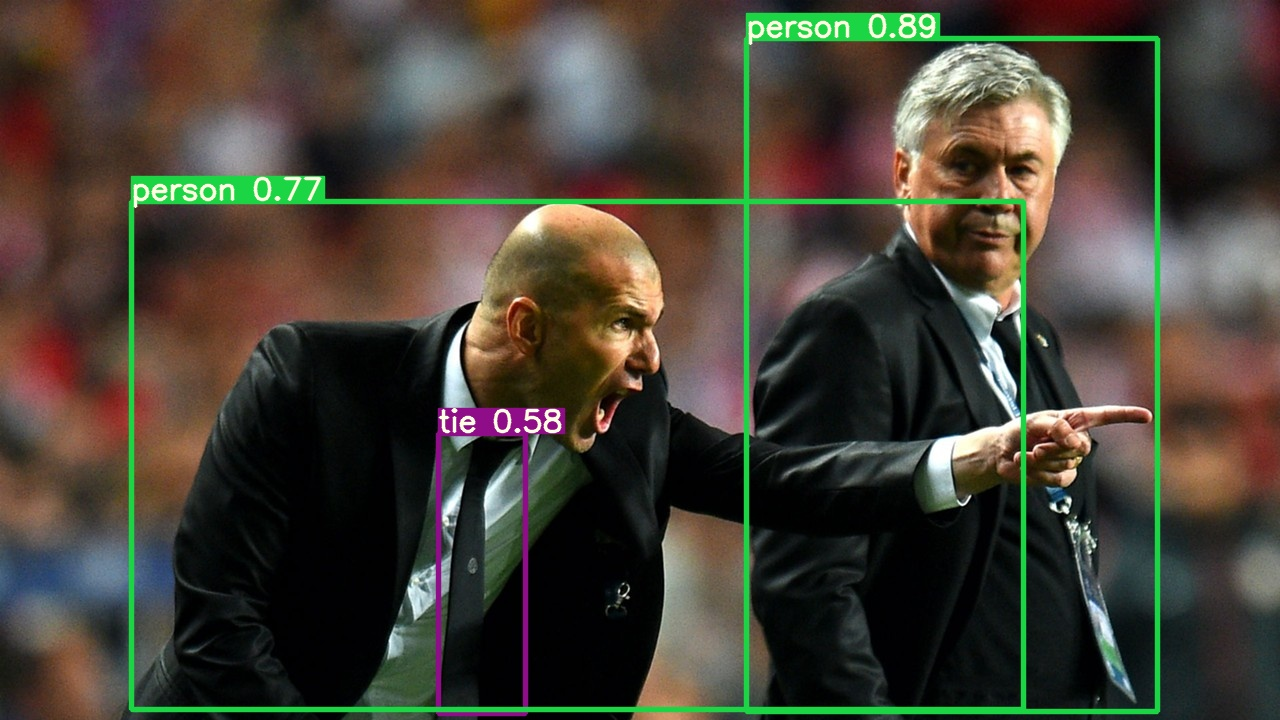

In [4]:
!python detect.py --weights yolov5s.pt --img 416 --conf 0.4 --source inference/images/
Image(filename='inference/output/zidane.jpg', width=600)

In [5]:
# Download coco128
gdrive_download('1n_oKgR81BJtqk75b00eAjdv03qVCQn2f','coco128.zip')  # coco128 dataset
!mv ./coco128 ../  # move folder alongside /yolov5

In [6]:
# Start tensorboard (optional)
%load_ext tensorboard
%tensorboard --logdir runs

In [7]:
# Train YOLOv5s on coco128 for 3 epochs
!python train.py --img 640 --batch 16 --epochs 7 --data coco128.yaml --cfg yolov5s.yaml --weights yolov5s.pt --nosave --cache

2020-09-12 07:04:01.199615: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1

Scanning images: 100%|██████████████████████| 128/128 [00:00<00:00, 4026.09it/s]
Scanning labels ../coco128/labels/train2017.cache (126 found, 0 missing, 2 empty, 0 duplicate, for 128 images): 128it [00:00, 10480.44it/s]
Caching images (0.1GB): 100%|████████████████| 128/128 [00:00<00:00, 159.36it/s]
Scanning labels ../coco128/labels/train2017.cache (126 found, 0 missing, 2 empty, 0 duplicate, for 128 images): 128it [00:00, 7959.19it/s]
Caching images (0.1GB): 100%|█████████████████| 128/128 [00:01<00:00, 97.65it/s]

Analyzing anchors... anchors/target = 4.27, Best Possible Recall (BPR) = 0.9946
       0/6        0G   0.04399   0.06078   0.01823     0.123       253       640
               Class      Images     Targets           P           R      mAP@.5
                 all         128         929       0.402       0.763       0.698       0

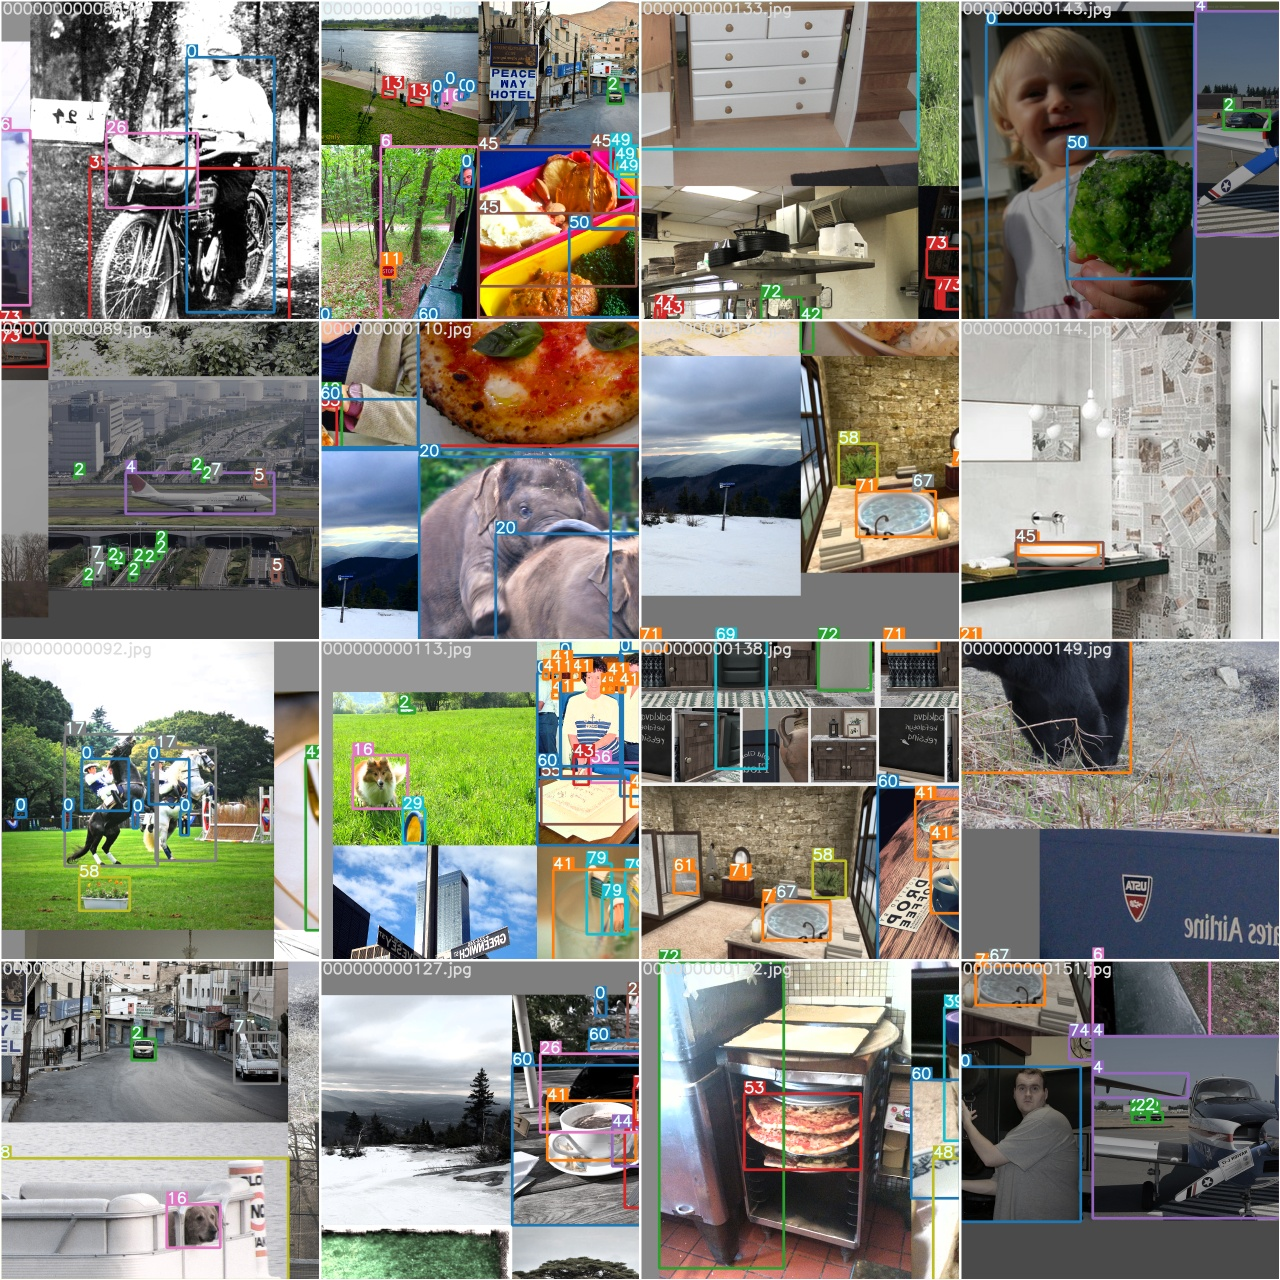

In [8]:
Image(filename='runs/exp0/train_batch1.jpg', width=900)  # view augmented training mosaics

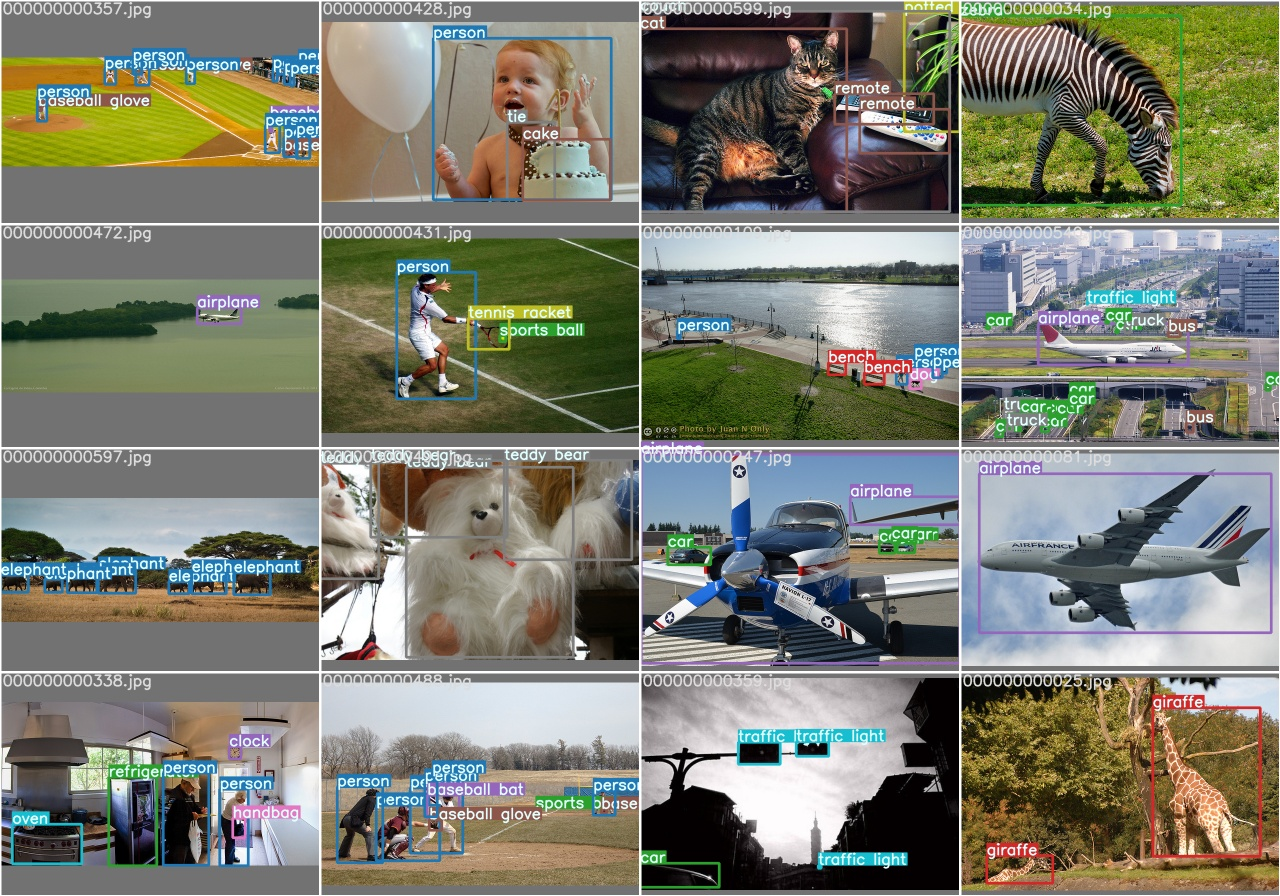

In [9]:
Image(filename='runs/exp0/test_batch0_gt.jpg', width=900)  # view test image labels

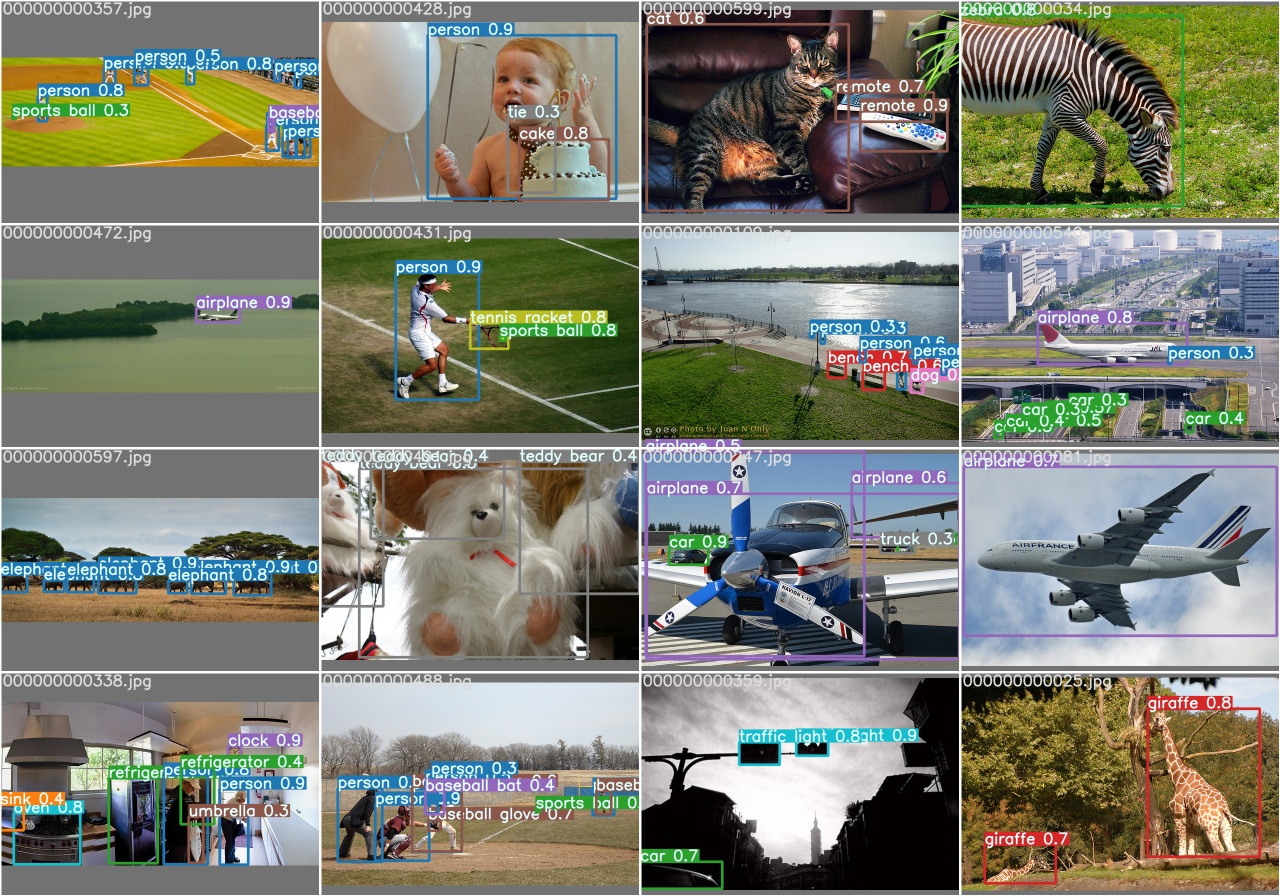

In [10]:
Image(filename='runs/exp0/test_batch0_pred.jpg', width=900)  # view test image predictions